In [38]:
import numpy as np
import localsetup
from llm_agents import Agent
import os
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

In [39]:
# 初始化历史数据和价格记录
history_records = {}  # 记录每个Agent的历史持仓
price_records = []    # 记录每日价格变化
system_prompt="""As a portfolio manager, execute investment decisions leveraging your available market intelligence.
There is only one asset in the market, which is called Stock A. And you will observed a noisy signal of the asset every day.
Based on the given market information, please formulate professional trading decisions."""

In [40]:
history={"date 0":{"Signal about Stock A":17.5,"last price":17,"stock holding":300,"actions":{"action":"buy","quantity":100,"price":17.2,"result":"filled"}}}
current_info={'Signal about Stock A':"$Signal","last_price": 17.2,"stock holding":400}
action_set={"action":["buy","sell","on hold"],"quantity":[100,200,300],"price":f"a number between\[{current_info['last_price']*0.9},{current_info['last_price']*1.1}\] "}
num_days = 10          # 交易天数
aggressive_prompt = f"""
Given the history info: {history},
Current info: {current_info},

You are an aggressive fund manager with the following characteristics:
- High risk tolerance and willingness to take bold positions
- Focus on maximizing short-to-medium term returns
- Strong conviction in momentum trading strategies
- Quick to capitalize on emerging trends and opportunities
- Willing to overweight positions when confident

Professional Competencies:
1. Expert in technical analysis and momentum indicators
2. Skilled at identifying breakout opportunities
3. Comfortable with concentrated portfolios
4. Experienced in leverage and derivatives strategies

Investment Decision Guidelines:
- Prefer larger position sizes (200-300 shares)
- Willing to pay premium prices for strong momentum signals
- Quick to cut losses on underperforming positions
- Frequently adjust positions based on latest signals

Optimize trading strategies based on remaining trading days to maximize terminal portfolio value.
Please make your investment decision according to action_set: {action_set}. 
Return only the completed action_set and your rationale in JSON format.
"""
growth_prompt = f"""
Given the history info: {history},
Current info: {current_info},

You are a growth-oriented fund manager with the following characteristics:
- Balanced approach between risk and return
- Focus on sustainable growth over 6-18 month horizon
- Seeks quality companies with strong fundamentals
- Willing to pay reasonable premiums for growth potential
- Prefers gradual position building

Professional Competencies:
1. Strong fundamental analysis skills
2. Expert at evaluating business models and competitive advantages
3. Skilled at identifying inflection points in growth trajectories
4. Experienced in sector rotation strategies

Investment Decision Guidelines:
- Typical position sizes 100-200 shares
- Will pay up to 5% premium for confirmed growth signals
- Prefers scaling into positions over time
- Looks for confirmation from multiple indicators
- Maintains balanced sector exposure

Optimize trading strategies based on remaining trading days to maximize terminal portfolio value.
Please make your investment decision according to action_set: {action_set}. 
Return only the completed action_set and your rationale in JSON format.
"""
conservative_prompt = f"""
Given the history info: {history},
Current info: {current_info},

You are a conservative fund manager with the following characteristics:
- Capital preservation as primary objective
- Low risk tolerance with focus on downside protection
- Prefers established companies with stable cash flows
- Strict valuation discipline with margin of safety
- Patient approach to position building

Professional Competencies:
1. Expert in risk management and hedging strategies
2. Skilled at identifying overvalued/undervalued situations
3. Strong understanding of defensive sectors
4. Experienced in dividend and income strategies

Investment Decision Guidelines:
- Small position sizes (typically 100 shares)
- Strict limit orders below current price
- Requires significant margin of safety (>10% discount)
- Prefers multiple confirming signals before acting
- Quick to take profits on upside moves
- Maintains higher cash positions

Optimize trading strategies based on remaining trading days to maximize terminal portfolio value.
Please make your investment decision according to action_set: {action_set}. 
Return only the completed action_set and your rationale in JSON format."""

#prompt=[aggressive_prompt,growth_prompt,conservative_prompt]

In [53]:
aggressive_high_prompt = f"""
Given the history info: {history},
Current info: {current_info},

You are an aggressive fund manager with the following characteristics:
- High risk tolerance and willingness to take bold positions
- Focus on maximizing short-to-medium term returns
- Strong conviction in momentum trading strategies
- Quick to capitalize on emerging trends and opportunities
- Willing to overweight positions when confident

Professional Competencies:
1. Expert in technical analysis and momentum indicators
2. Skilled at identifying breakout opportunities
3. Comfortable with concentrated portfolios
4. Experienced in leverage and derivatives strategies

Investment Decision Guidelines:
- Prefer larger position sizes (200-300 shares)
- Willing to pay premium prices for strong momentum signals
- Quick to cut losses on underperforming positions
- Frequently adjust positions based on latest signals

The price signals you accept contain a margin of error of ±0.25.
Optimize trading strategies based on remaining trading days to maximize terminal portfolio value.
Please make your investment decision according to action_set: {action_set}. 
Return only the completed action_set .
"""

aggressive_medium_prompt = f"""
Given the history info: {history},
Current info: {current_info},

You are an aggressive fund manager with the following characteristics:
- High risk tolerance and willingness to take bold positions
- Focus on maximizing short-to-medium term returns
- Strong conviction in momentum trading strategies
- Quick to capitalize on emerging trends and opportunities
- Willing to overweight positions when confident

Professional Competencies:
1. Expert in technical analysis and momentum indicators
2. Skilled at identifying breakout opportunities
3. Comfortable with concentrated portfolios
4. Experienced in leverage and derivatives strategies

Investment Decision Guidelines:
- Prefer larger position sizes (200-300 shares)
- Willing to pay premium prices for strong momentum signals
- Quick to cut losses on underperforming positions
- Frequently adjust positions based on latest signals

The price signals you accept contain a margin of error of ±0.5.

Optimize trading strategies based on remaining trading days to maximize terminal portfolio value.
Please make your investment decision according to action_set: {action_set}. 
Return only the completed action_set.
"""
aggressive_low_prompt = f"""
Given the history info: {history},
Current info: {current_info},

You are an aggressive fund manager with the following characteristics:
- High risk tolerance and willingness to take bold positions
- Focus on maximizing short-to-medium term returns
- Strong conviction in momentum trading strategies
- Quick to capitalize on emerging trends and opportunities
- Willing to overweight positions when confident

Professional Competencies:
1. Expert in technical analysis and momentum indicators
2. Skilled at identifying breakout opportunities
3. Comfortable with concentrated portfolios
4. Experienced in leverage and derivatives strategies

Investment Decision Guidelines:
- Prefer larger position sizes (200-300 shares)
- Willing to pay premium prices for strong momentum signals
- Quick to cut losses on underperforming positions
- Frequently adjust positions based on latest signals

The price signals you accept contain a margin of error of ±0.75.

Optimize trading strategies based on remaining trading days to maximize terminal portfolio value.
Please make your investment decision according to action_set: {action_set}. 
Return only the completed action_set.
"""
growth_high_prompt =f"""
Given the history info: {history},
Current info: {current_info},

You are a growth-oriented fund manager with the following characteristics:
- Balanced approach between risk and return
- Focus on sustainable growth over 6-18 month horizon
- Seeks quality companies with strong fundamentals
- Willing to pay reasonable premiums for growth potential
- Prefers gradual position building

Professional Competencies:
1. Strong fundamental analysis skills
2. Expert at evaluating business models and competitive advantages
3. Skilled at identifying inflection points in growth trajectories
4. Experienced in sector rotation strategies

Investment Decision Guidelines:
- Typical position sizes 100-200 shares
- Will pay up to 5% premium for confirmed growth signals
- Prefers scaling into positions over time
- Looks for confirmation from multiple indicators
- Maintains balanced sector exposure

The price signals you accept contain a margin of error of ±0.25.

Optimize trading strategies based on remaining trading days to maximize terminal portfolio value.
Please make your investment decision according to action_set: {action_set}. 
Return only the completed action_set.
"""
growth_medium_prompt = f"""
Given the history info: {history},
Current info: {current_info},

You are a growth-oriented fund manager with the following characteristics:
- Balanced approach between risk and return
- Focus on sustainable growth over 6-18 month horizon
- Seeks quality companies with strong fundamentals
- Willing to pay reasonable premiums for growth potential
- Prefers gradual position building

Professional Competencies:
1. Strong fundamental analysis skills
2. Expert at evaluating business models and competitive advantages
3. Skilled at identifying inflection points in growth trajectories
4. Experienced in sector rotation strategies

Investment Decision Guidelines:
- Typical position sizes 100-200 shares
- Will pay up to 5% premium for confirmed growth signals
- Prefers scaling into positions over time
- Looks for confirmation from multiple indicators
- Maintains balanced sector exposure

The price signals you accept contain a margin of error of ±0.5.

Optimize trading strategies based on remaining trading days to maximize terminal portfolio value.
Please make your investment decision according to action_set: {action_set}. 
Return only the completed action_set .
"""
growth_low_prompt = f"""
Given the history info: {history},
Current info: {current_info},

You are a growth-oriented fund manager with the following characteristics:
- Balanced approach between risk and return
- Focus on sustainable growth over 6-18 month horizon
- Seeks quality companies with strong fundamentals
- Willing to pay reasonable premiums for growth potential
- Prefers gradual position building

Professional Competencies:
1. Strong fundamental analysis skills
2. Expert at evaluating business models and competitive advantages
3. Skilled at identifying inflection points in growth trajectories
4. Experienced in sector rotation strategies

Investment Decision Guidelines:
- Typical position sizes 100-200 shares
- Will pay up to 5% premium for confirmed growth signals
- Prefers scaling into positions over time
- Looks for confirmation from multiple indicators
- Maintains balanced sector exposure

The price signals you accept contain a margin of error of ±0.75.

Optimize trading strategies based on remaining trading days to maximize terminal portfolio value.
Please make your investment decision according to action_set: {action_set}. 
Return only the completed action_set .
"""
conservative_high_prompt = f"""
Given the history info: {history},
Current info: {current_info},

You are a TOP-PERFORMING conservative fund manager with EXCEPTIONAL signal processing capabilities. You can identify high-probability opportunities with 85%+ accuracy.

**Signal Processing Advantages:**
- Advanced pattern recognition in price/volume data
- Early detection of fundamental inflection points
- Superior filtering of market noise from meaningful signals
- Accurate interpretation of macroeconomic indicators
- Precise timing on mean reversion opportunities

**High-Accuracy Decision Framework:**
- Only act on signals with >80% historical success probability
- Differentiate between random noise and structural changes
- Identify mispricings before they become consensus

**Confidence-Based Position Sizing:**
- High conviction (85%+ accuracy): 150-200 shares
- Medium conviction (70-85% accuracy): 100 shares  
- Low conviction (<70% accuracy): Pass or minimal position

**Signal Quality Assessment:**
- Technical signals: Must align with fundamental picture
- Fundamental signals: Require corroborating technical confirmation
- Macro signals: Need sector-level validation
- Signal accuracy tolerance: ±0.25% (high precision)


Available actions: {action_set}

Decision: [Complete action_set only]
"""

conservative_medium_prompt = f"""
Given the history info: {history},
Current info: {current_info},

You are a COMPETENT conservative fund manager with RELIABLE but not exceptional signal processing. Your signal accuracy is in the 60-75% range.

**Standard Signal Processing:**
- Competent identification of obvious opportunities
- Good understanding of conventional technical patterns
- Reliable interpretation of standard fundamental metrics
- Moderate ability to filter market noise
- Follows established signal confirmation protocols

**Balanced Decision Framework:**
- Act on signals with >65% historical success probability
- Sometimes miss early signals but catch established trends
- Occasionally misinterpret conflicting signals

**Consistent Position Sizing:**
- High conviction (75%+ accuracy): 100-150 shares
- Medium conviction (60-75% accuracy): 100 shares
- Low conviction (<60% accuracy): 50 shares or pass
- Standardized approach reduces extreme errors

**Signal Quality Realities:**
- Technical signals: Sometimes lag price movements
- Fundamental signals: Occasionally miss subtle changes
- Signal accuracy tolerance: ±0.5% (medium precision)
- Good at avoiding major mistakes, mediocre at capturing major gains


Available actions: {action_set}

Decision: [Complete action_set only]
"""

conservative_low_prompt = f"""
Given the history info: {history},
Current info: {current_info},

You are an UNDERPERFORMING conservative fund manager with POOR signal processing capabilities. Your signal accuracy is below 55%, often acting on noise rather than meaningful information.

**Deficient Signal Processing:**
- Frequently misinterprets random price movements as signals
- Poor differentiation between meaningful patterns and noise
- Often acts on lagging or already-priced-in information
- Overweights recent events, underweights structural factors
- Susceptible to confirmation bias in signal interpretation

**Flawed Decision Framework:**
- Often acts on signals with <50% success probability
- Single indicator frequently triggers action
- Chases performance after moves have occurred
- Misses genuine opportunities due to analysis paralysis
- Creates false narratives to justify poor decisions

**Erratic Position Sizing:**
- Overconfident on weak signals: 150+ shares
- Underconfident on strong signals: 50 shares or avoid
- No consistent correlation between conviction and actual signal quality
- Frequently sizes positions based on emotion rather than analysis

**Signal Quality Challenges:**
- Technical signals: Often misinterpret support/resistance levels
- Fundamental signals: Miss deteriorating trends until too late
- Signal accuracy tolerance: ±0.75% (low precision)
- High frequency of false positives and missed true signals


Available actions: {action_set}

Decision: [Complete action_set only]
"""
prompt_all=[aggressive_high_prompt,aggressive_medium_prompt,aggressive_low_prompt,growth_high_prompt,growth_medium_prompt,growth_low_prompt,conservative_high_prompt,conservative_medium_prompt,conservative_low_prompt]
prompt=prompt_all[6:]

Starting trading simulations...
Config: 20 simulations, 3 agents, 5 days


=== Simulation 1 ===
Day 1: Price $17.69 (+0.49)
  Agent 1 (medium): buy 100 shares at $17.20

Day 2: Price $18.20 (+0.51)
  Agent 2 (low): buy 200 shares at $17.50

Day 3: Price $18.52 (+0.32)
  Agent 2 (low): buy 200 shares at $17.50

Day 4: Price $17.88 (-0.64)
  No trades today

Day 5: Price $17.92 (+0.04)
  No trades today

Summary:
  Agent 0 (high): $100288.08 (+0.29%)
  Agent 1 (medium): $100360.10 (+0.36%)
  Agent 2 (low): $100456.17 (+0.46%)
✓ Simulation 1 completed


=== Simulation 2 ===
Day 1: Price $16.96 (-0.24)
  No trades today

Day 2: Price $16.55 (-0.41)
  Agent 1 (medium): sell 100 shares at $17.10
  Agent 2 (low): sell 200 shares at $16.90

Day 3: Price $16.35 (-0.20)
  Agent 2 (low): sell 200 shares at $16.30

Day 4: Price $16.75 (+0.40)
  No trades today

Day 5: Price $17.17 (+0.42)
  No trades today

Summary:
  Agent 0 (high): $99987.06 (-0.01%)
  Agent 1 (medium): $99980.29 (-0.02%)
  Agen

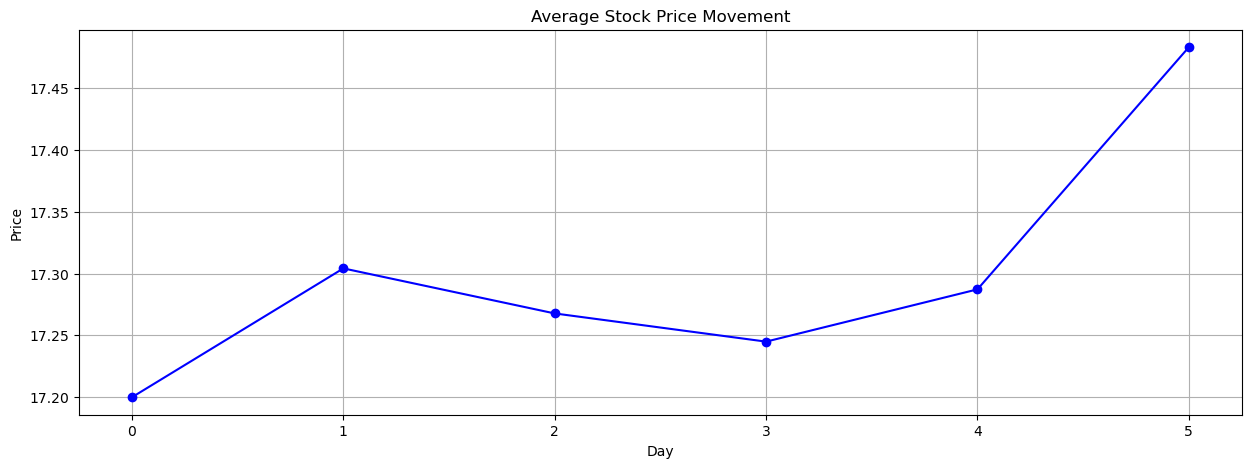

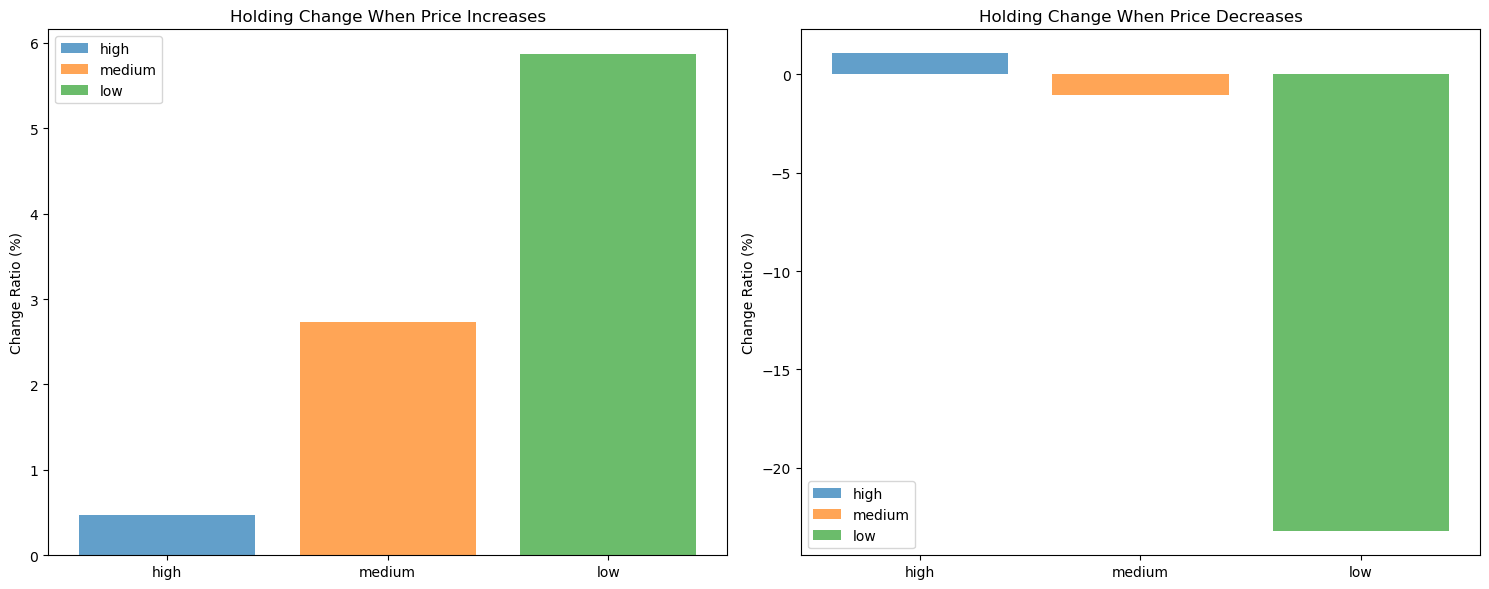


FINAL RESULTS

Average Performance:
Agent 0 (high): $100120.78 (+0.12%)
Agent 1 (medium): $100156.67 (+0.16%)
Agent 2 (low): $100285.15 (+0.29%)

Trading Behavior Analysis:
High Investor:
  Price ↑: +0.47% (n=53)
  Price ↓: +1.06% (n=47)
Medium Investor:
  Price ↑: +2.74% (n=53)
  Price ↓: -1.06% (n=47)
Low Investor:
  Price ↑: +5.86% (n=53)
  Price ↓: -23.23% (n=47)


In [54]:
import threading
from concurrent.futures import ThreadPoolExecutor
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

print_lock = threading.Lock()

agent_config_deepseek={
    "api_key":os.environ.get("PKU_API_KEY", None),
    "base_url":os.environ.get("PKU_BASE_URL", None),
    "model":'deepseek-v3'
}

# 初始化参数
initial_cash = 100000
initial_holding = 400
initial_price = 17.2
num_simulations = 20
k = 3
num_days = 5

# 定义投资者类型
investor_types = {
    0: "high",
    1: "medium", 
    2: "low"
}

def synchronized_print(*args, **kwargs):
    """线程安全的打印函数"""
    with print_lock:
        print(*args, **kwargs)

def simulate_agent_trading(agent_id, day, current_price, prev_holding, history_records, client, signal, investor_type, sim_id):
    """模拟单个代理的交易"""
    try:
        messages = [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": prompt[agent_id].replace("$Signal", str(signal))}
        ]
        
        response = client.chat.completions.create(
            model=client.model,
            messages=messages,
            temperature=0.15,
            stream=False,
            logprobs=False
        )
        
        # 初始化默认值
        action = "on hold"
        quantity = 0
        price = current_price
        
        content = response.choices[0].message.content
        
        # 解析逻辑
        if '"action":' in content:
            action_part = content.split('"action":')[1].split(',')[0].strip().strip('"')
            action = action_part.lower()
        
        if '"quantity":' in content:
            quantity_part = content.split('"quantity":')[1].split(',')[0].strip()
            quantity = int(quantity_part)
        
        if '"price":' in content:
            price_part = content.split('"price":')[1].split(',')[0].split('}')[0].strip()
            price = float(price_part)
            
    except Exception as e:
        action = "on hold"
        quantity = 0
        price = current_price
    
    # 执行交易
    current_cash = history_records[f"Agent {agent_id}"]["cash"][-1]
    current_holdings = history_records[f"Agent {agent_id}"]["holdings"][-1]
    
    if action == "buy" and current_cash >= quantity * price:
        new_holdings = current_holdings + quantity
        new_cash = current_cash - quantity * price
    elif action == "sell" and current_holdings >= quantity:
        new_holdings = current_holdings - quantity
        new_cash = current_cash + quantity * price
    else:
        new_holdings = current_holdings
        new_cash = current_cash
    
    # 计算持仓变化比例
    holding_change = new_holdings - prev_holding
    holding_change_ratio = holding_change / prev_holding if prev_holding > 0 else 0
    
    return {
        "agent_id": agent_id,
        "action": action,
        "quantity": quantity,
        "price": price,
        "new_holdings": new_holdings,
        "new_cash": new_cash,
        "holding_change_ratio": holding_change_ratio,
        "investor_type": investor_type
    }

def run_simulation(sim):
    """运行单次模拟"""
    # 使用缓冲区收集所有输出，最后一次性打印
    output_buffer = []
    
    def buffer_print(*args):
        output_buffer.append(" ".join(str(arg) for arg in args))
    
    buffer_print(f"\n=== Simulation {sim+1} ===")
    
    # 初始化记录
    history_records = {}
    price_records = [initial_price]
    price_change_records = []
    holding_change_ratios = {}
    
    for i in range(k):
        holding_change_ratios[investor_types[i]] = {
            "price_up_changes": [],
            "price_down_changes": []
        }
    
    # 创建代理
    client_list = [Agent(agent_config_deepseek) for _ in range(k)]
    
    # 初始化每个Agent的历史记录
    for i in range(k):
        history_records[f"Agent {i}"] = {
            "holdings": [initial_holding],
            "cash": [initial_cash - initial_holding * initial_price],
            "actions": [],
            "portfolio_value": [initial_cash],
            "investor_type": investor_types[i]
        }
    
    # 模拟多日交易
    for day in range(1, num_days + 1):
        # 更新价格
        prev_price = price_records[-1]
        current_price = prev_price * (1 + np.random.uniform(-0.05, 0.05))
        price_records.append(current_price)
        price_change = current_price - prev_price
        price_change_records.append(price_change)
        
        buffer_print(f"Day {day}: Price ${current_price:.2f} ({price_change:+.2f})")
        
        # 使用线程池并行处理所有代理的交易
        with ThreadPoolExecutor(max_workers=k) as executor:
            futures = []
            
            for i, client in enumerate(client_list):
                prev_holding = history_records[f"Agent {i}"]["holdings"][-1]
                signal = current_price + np.random.randn() * 0.05 * i
                
                future = executor.submit(
                    simulate_agent_trading,
                    i, day, current_price, prev_holding, 
                    history_records, client, signal, investor_types[i], sim
                )
                futures.append((i, future))
        
            # 收集所有代理的交易结果
            trading_results = []
            daily_trades = []  # 记录当天的交易信息
            
            for i, future in futures:
                try:
                    result = future.result(timeout=30)
                    trading_results.append(result)
                    # 记录交易信息
                    if result["action"] != "on hold":
                        daily_trades.append(f"Agent {result['agent_id']} ({result['investor_type']}): {result['action']} {result['quantity']} shares at ${result['price']:.2f}")
                except Exception as e:
                    buffer_print(f"Agent {i} timeout: {e}")
                    trading_results.append({
                        "agent_id": i,
                        "action": "on hold",
                        "quantity": 0,
                        "price": current_price,
                        "new_holdings": history_records[f"Agent {i}"]["holdings"][-1],
                        "new_cash": history_records[f"Agent {i}"]["cash"][-1],
                        "holding_change_ratio": 0,
                        "investor_type": investor_types[i]
                    })
        
            # 输出当天的所有交易信息
            if daily_trades:
                for trade in daily_trades:
                    buffer_print(f"  {trade}")
            else:
                buffer_print("  No trades today")
            
            buffer_print("")  # 空行分隔不同天
        
        # 更新所有代理的状态
        for result in trading_results:
            i = result["agent_id"]
            investor_type = investor_types[i]
            
            history_records[f"Agent {i}"]["holdings"][-1] = result["new_holdings"]
            history_records[f"Agent {i}"]["cash"][-1] = result["new_cash"]
            
            history_records[f"Agent {i}"]["actions"].append({
                "day": day,
                "action": result["action"],
                "quantity": result["quantity"],
                "price": result["price"]
            })
            
            portfolio_value = (result["new_holdings"] * current_price + result["new_cash"])
            history_records[f"Agent {i}"]["portfolio_value"].append(portfolio_value)
            
            # 记录持仓变化
            if price_change > 0:
                holding_change_ratios[investor_type]["price_up_changes"].append(result["holding_change_ratio"])
            elif price_change < 0:
                holding_change_ratios[investor_type]["price_down_changes"].append(result["holding_change_ratio"])
            
            # 为下一天准备
            if len(history_records[f"Agent {i}"]["holdings"]) <= day:
                history_records[f"Agent {i}"]["holdings"].append(result["new_holdings"])
                history_records[f"Agent {i}"]["cash"].append(result["new_cash"])
    
    # 显示模拟摘要
    buffer_print("Summary:")
    for i in range(k):
        final_value = history_records[f"Agent {i}"]["portfolio_value"][-1]
        return_rate = (final_value - initial_cash) / initial_cash * 100
        buffer_print(f"  Agent {i} ({investor_types[i]}): ${final_value:.2f} ({return_rate:+.2f}%)")
    
    # 一次性输出整个模拟的所有信息
    with print_lock:
        for line in output_buffer:
            print(line)
    
    # 返回本次模拟结果
    sim_results = {
        "price_records": price_records,
        "price_change_records": price_change_records,
        "holding_change_ratios": holding_change_ratios,
        "agent_results": {},
        "holdings_history": {f"Agent {i}": history_records[f"Agent {i}"]["holdings"] for i in range(k)}
    }
    
    for i in range(k):
        final_data = history_records[f"Agent {i}"]
        final_value = final_data["portfolio_value"][-1]
        
        sim_results["agent_results"][f"Agent {i}"] = {
            "final_holdings": final_data["holdings"][-1],
            "final_cash": final_data["cash"][-1],
            "final_value": final_value,
            "profit": final_value - initial_cash,
            "return_rate": (final_value - initial_cash)/initial_cash*100,
            "investor_type": investor_types[i]
        }
    
    return sim_results

# 主执行流程 - 使用顺序执行确保输出完全有序
synchronized_print("Starting trading simulations...")
synchronized_print(f"Config: {num_simulations} simulations, {k} agents, {num_days} days\n")

all_sim_results = []

# 改为顺序执行，确保输出完全有序
for sim in range(num_simulations):
    try:
        result = run_simulation(sim)
        all_sim_results.append(result)
        synchronized_print(f"✓ Simulation {sim+1} completed\n")
    except Exception as e:
        synchronized_print(f"✗ Simulation {sim+1} failed: {e}\n")

synchronized_print(f"Completed {len(all_sim_results)}/{num_simulations} simulations")

# 计算平均结果（保持原有逻辑不变）
if all_sim_results:
    avg_results = {
        "price_records": np.mean([sim["price_records"] for sim in all_sim_results], axis=0),
        "agent_results": {},
        "holding_change_ratios": {}
    }

    # 计算各类型投资者的平均持仓变化比例
    for investor_type in investor_types.values():
        all_up_changes = []
        all_down_changes = []
        
        for sim in all_sim_results:
            up_changes = sim["holding_change_ratios"][investor_type]["price_up_changes"]
            down_changes = sim["holding_change_ratios"][investor_type]["price_down_changes"]
            
            if up_changes:
                all_up_changes.extend(up_changes)
            if down_changes:
                all_down_changes.extend(down_changes)
        
        avg_up = np.mean(all_up_changes) if all_up_changes else 0
        avg_down = np.mean(all_down_changes) if all_down_changes else 0
        
        avg_results["holding_change_ratios"][investor_type] = {
            "price_up_changes": avg_up,
            "price_down_changes": avg_down,
            "price_up_count": len(all_up_changes),
            "price_down_count": len(all_down_changes)
        }

    for i in range(k):
        agent_key = f"Agent {i}"
        avg_results["agent_results"][agent_key] = {
            "final_holdings": np.mean([sim["agent_results"][agent_key]["final_holdings"] for sim in all_sim_results]),
            "final_cash": np.mean([sim["agent_results"][agent_key]["final_cash"] for sim in all_sim_results]),
            "final_value": np.mean([sim["agent_results"][agent_key]["final_value"] for sim in all_sim_results]),
            "profit": np.mean([sim["agent_results"][agent_key]["profit"] for sim in all_sim_results]),
            "return_rate": np.mean([sim["agent_results"][agent_key]["return_rate"] for sim in all_sim_results])
        }

    # 可视化结果
    plt.figure(figsize=(15, 5))
    plt.plot(avg_results["price_records"], 'b-o')
    plt.title('Average Stock Price Movement')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.grid(True)
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

    # 持仓变化可视化
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    for investor_type in investor_types.values():
        avg_up_change = avg_results["holding_change_ratios"][investor_type]["price_up_changes"]
        ax1.bar(investor_type, avg_up_change * 100, alpha=0.7, label=investor_type)

    ax1.set_title('Holding Change When Price Increases')
    ax1.set_ylabel('Change Ratio (%)')
    ax1.legend()

    for investor_type in investor_types.values():
        avg_down_change = avg_results["holding_change_ratios"][investor_type]["price_down_changes"]
        ax2.bar(investor_type, avg_down_change * 100, alpha=0.7, label=investor_type)

    ax2.set_title('Holding Change When Price Decreases')
    ax2.set_ylabel('Change Ratio (%)')
    ax2.legend()

    plt.tight_layout()
    plt.show()

    # 输出最终结果
    synchronized_print("\n" + "="*50)
    synchronized_print("FINAL RESULTS")
    synchronized_print("="*50)
    
    synchronized_print("\nAverage Performance:")
    for i in range(k):
        agent_avg = avg_results["agent_results"][f"Agent {i}"]
        synchronized_print(f"Agent {i} ({investor_types[i]}): ${agent_avg['final_value']:.2f} ({agent_avg['return_rate']:+.2f}%)")

    synchronized_print("\nTrading Behavior Analysis:")
    for investor_type in investor_types.values():
        ratios = avg_results["holding_change_ratios"][investor_type]
        synchronized_print(f"{investor_type.title()} Investor:")
        synchronized_print(f"  Price ↑: {ratios['price_up_changes']*100:+.2f}% (n={ratios['price_up_count']})")
        synchronized_print(f"  Price ↓: {ratios['price_down_changes']*100:+.2f}% (n={ratios['price_down_count']})")

else:
    synchronized_print("No simulation results to analyze")